# Fisher Analysis of the Network

This notebook demonstrates using the Fisher Information to calculate generalisability and trainability metrics

In [1]:
import os
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import PIL
from torchsummary import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import configparser as ConfigParser

from utils import *
# Ipmport various network architectures
from networks import AGRadGalNet, VanillaLeNet, testNet, DNSteerableLeNet, DNSteerableAGRadGalNet
# Import various data classes
from datasets import FRDEEPF
from datasets import MiraBest_full, MBFRConfident, MBFRUncertain, MBHybrid
from datasets import MingoLoTSS, MLFR, MLFRTest
import torch.nn.functional as F

Load in the dataset and the relevant configuration

In [2]:
PATH = "configs/"
cfg_base = "C4_attention_mirabest.cfg"
config = ConfigParser.ConfigParser(allow_no_value=True)
config.read(PATH + cfg_base)
device = "cuda"

train_loader, valid_loader  = utils.data.load(
    config, 
    train=True, 
    augmentation='config', 
    data_loader=True
)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5],[0.5])])

Files already downloaded and verified


/raid/scratch/mattyb/venv/lib/python3.8/site-packages/torchvision/transforms/transforms.py:1314: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  warnings.warn(


In [3]:
print(f"Loading in {config['model']['base']}")
net = locals()[config['model']['base']](**config['model']).to(device)

quiet = config.getboolean('DEFAULT', 'quiet')
early_stopping = config.getboolean('training', 'early_stopping')

# Read / Create Folder for Data to be Saved
root = config['data']['directory']
os.makedirs(root, exist_ok=True)

if not quiet:
    if 'DN' not in config['model']['base']:
        summary(net, (1, 150, 150))
    print(device)
    if device == torch.device('cuda'):
        summary(net, (1,150,150))
        print(torch.cuda.get_device_name(device=device))

Loading in DNSteerableAGRadGalNet


/raid/scratch/mattyb/venv/lib/python3.8/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:61: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  sampled_basis = sampled_basis[mask, ...]


cuda


Attempt to load in the best saved model

In [4]:
path_supliment = config['data']['augment']+'/'
model = utils.utils.load_model(config, load_model='best', device=device, path_supliment=path_supliment)

Save the Model Weights and then Train the Last Layer to ensure the grad information is retained

In [5]:
utils.fisher.WeightTransfer(model, net)

In [6]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.0001)

Function to obtain the Jacobian using the Torch AutoGrad

In [7]:
Fishers, Rank, FR = utils.fisher.CalcFIM(net, train_loader, 10)

Calculating 10 of the Fisher...


  0%|          | 0/10 [00:00<?, ?it/s]/raid/scratch/mattyb/venv/lib/python3.8/site-packages/torch/nn/functional.py:3451: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


Calculating values of the Fisher Information Matrix manually (not using the imports)

Example Plots of the Fisher Information Matrix

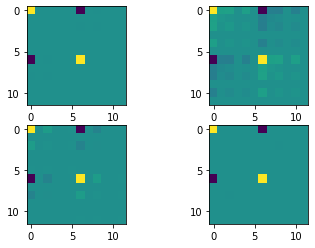

In [8]:
f, axarr = plt.subplots(2,2)

axarr[0,0].imshow(Fishers[0].cpu())
axarr[0,1].imshow(Fishers[1].cpu())
axarr[1,0].imshow(Fishers[2].cpu())
axarr[1,1].imshow(Fishers[3].cpu())

Eigenvalue Distribution of the Fisher Information Matrix

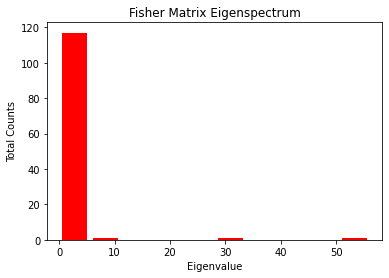

In [12]:
EV =[]
#normalise fisher
normalised_fishers = utils.fisher.normalise(Fishers.cpu())

#Calculate Positive Eigenvalues
for i in normalised_fishers:
    EV = np.append(EV,torch.eig(i, eigenvectors=False,  out=None)[0][:,0].detach().numpy())
#Plot Them
plt.subplot(111)
nbins = 10
plt.hist(EV, bins=nbins, rwidth=0.8, color='r')
plt.ylabel("Total Counts")
plt.xlabel("Eigenvalue")
plt.title("Fisher Matrix Eigenspectrum")
plt.show()

Rank Distribution of the Obtained Realisations of the Fisher Information Matrix

The Mean Rank obtained is 4.8 



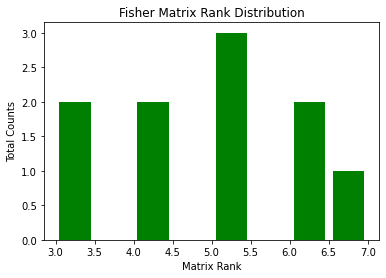

In [10]:
plt.subplot(111)
nbins = 8
plt.hist(Rank, bins=nbins, rwidth=0.8, color='g')
plt.ylabel("Total Counts")
plt.xlabel("Matrix Rank")
plt.title("Fisher Matrix Rank Distribution")
MeanRank = np.mean(Rank)
print(f"The Mean Rank obtained is {MeanRank} \n")
plt.savefig('VanillaRank.png')
plt.show()

Fisher Rao Norm Distribution

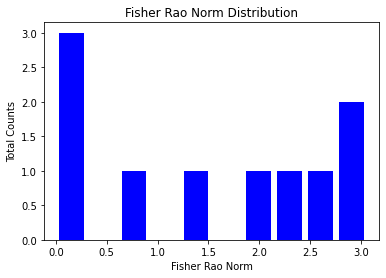

In [11]:
plt.subplot(111)
nbins = 10
FR2 = [np.abs(e) for e in FR]
plt.hist(FR2, bins=nbins, rwidth = 0.8 ,color='b')
plt.ylabel("Total Counts")
plt.xlabel("Fisher Rao Norm")
plt.title("Fisher Rao Norm Distribution")
plt.savefig('VanillaRao.png')
plt.show()